# Siamese network using Subset of MNIST data

## Logics behind this notebook  

Before going this Jupyter Notebook, you are strongly recommended to go through the Jupyter Notebook for Siamese Network using the full MNIST dataset. You may ask why this notebook if it actually solves the same problem. 

What really upsets me in the Jupyter Notebook using the full set of MNIST data is that it takes forever to train the model while we have actually only $10$ classes. Using $60000$ training examples to a database of $10$ digits (or $10$ persons). Therefore, I decided to write this Jupyter Notebook to use a subset of the full MNIST dataset.

You will see that most of the code in this Notebook is exactly the same as that in <font color='yellow'>"siamese-BCE-mnist-fullset.ipynb"</font>. The key difference is that I will define a subset of the original full MNIST dataset.

In [37]:
# First thing first:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision import transforms as T
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from tqdm import tqdm

## Generate dataset

Again, you are strongly recommended to learn the Jupyter Notebook <font color='yellow'>"siamese-BCE-mnist-fullset.ipynb"</font> before.

### Subset of MNIST database

We will start with create a dataset with the size of only $1/20$ the original data size. That is, we use only $3000$ images for the training database and $300$ for the test database. You can use bigger or smaller size according to you experiment.

**[1] Simple approach**  
The first straightforward idea to do this is to take the first $3000$ images in the database. In this way, we may or may not end up with quite skewed dataset in which we may have many more images for one particular digit than those of other digits. Although this strategy may not lead to a very skewed dataset if the original dataset has been uniformed distributed.

**[2] Perfectly partitioned approach**  
My idea is to generate a perfectly partititioned subset of MNIST database. For example, if we create a dataset of $3000$ images, we can allocate $300$ images for the digit $0$, $300 images for the digit $1$, and so on. In this manner, we have a partitioned subset of MNIST database. To do this, we divide original images into $10$ groups 
$$
\mathbf{G}\{0\} \qquad \mathbf{G}\{1 \} \qquad \cdots \qquad \mathbf{G}\{9\}
$$
Then, for each group we take randomly exactly $300$ images. 

**Our approach**  
We will create the subset using the second approach [2].

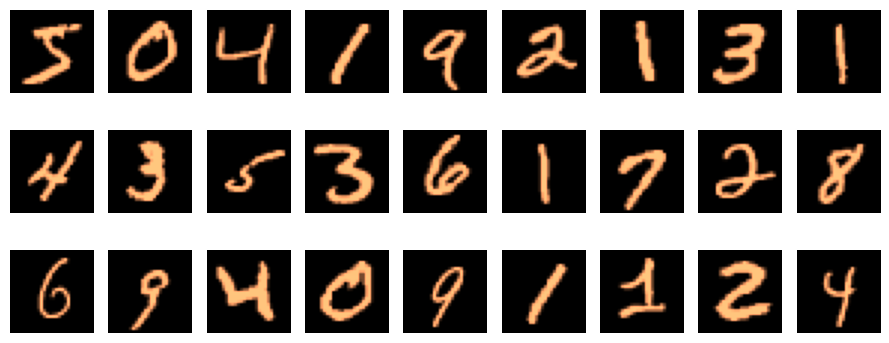

In [38]:
mnist_database = datasets.MNIST(root='./data', train=True, download=True)

nrows, ncols = 3, 9
plt.figure(figsize=(9, 4))
for i in range(nrows * ncols):
    plt.subplot(nrows, ncols, i + 1)
    plt.imshow(mnist_database.data[i], cmap='copper')
    plt.axis('off')
plt.tight_layout()

In [39]:
class SubMNIST(Dataset):
    def __init__(self, root, train=True, download=True, datasize=60000):

        # Download the MNIST dataset and store it into the variable. We attach this
        # variable to "self" although it is unnecessary at this step.

        # The dataset has two members "data" and "targets". The member data refer to images
        self.dataset = datasets.MNIST(root=root, train=train, download=download)


        unsqueezed_data = self.dataset.data.clone()
        grouped_examples = {}
        for digit in range(0, 10):
            grouped_examples[digit] = np.where(self.dataset.targets == digit)[0]
        
        imsize = (28, 28)       # only 1 channel
        self.data = torch.zeros(size=(datasize, *imsize))
        self.targets = torch.zeros(datasize)

        # For perfectly partitioned dataset you should use datasize that is 
        # divisible by 10. The category size is of course defined by datasize/10.
        category_size = int(datasize // 10)
        # Take category_size images for each digit.
        for digit in range(0, 10):
            idx = digit * category_size
            self.data[idx:idx+category_size] = unsqueezed_data[grouped_examples[digit][0:category_size]]
            self.targets[idx:idx+category_size] = self.dataset.targets[grouped_examples[digit][0:category_size]]

        # After for loop, the images for the digits are ordered in the ascending order
        # for 0, 1, 2, ..., 9. Therefore, we need to randomly permute the created dataset.
        rand_permute = torch.randperm(datasize)
        self.data = self.data[rand_permute]
        self.targets = self.targets[rand_permute]

    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, index):
        return (self.data[index], self.targets[index])

In [40]:
# Create datasets
train_submnist = SubMNIST(root='./data', train=True, download=True, datasize=3000)
test_submnist = SubMNIST(root='./data', train=False, download=True, datasize= 300)

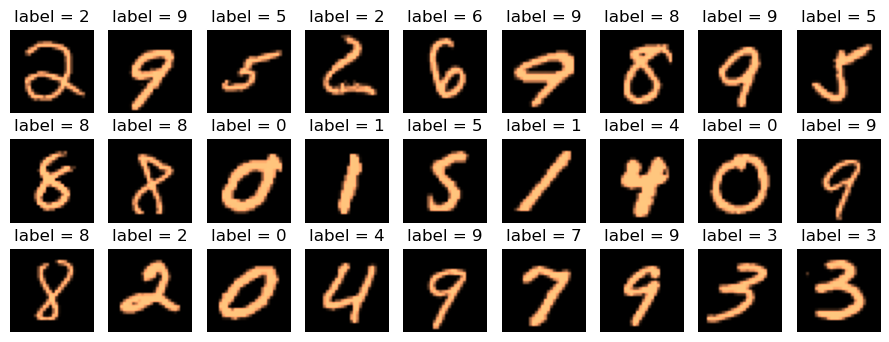

In [41]:
# Let us visualize some images from the dataset we just created.
plt.figure(figsize=(9, 3.5))
nrows, ncols = 3, 9
for j in range(nrows*ncols):
    plt.subplot(nrows, ncols, j+1)
    idx = np.random.randint(0, len(train_submnist))
    img = train_submnist[idx][0].squeeze().numpy()
    plt.imshow(img, cmap='copper')
    plt.axis('off')
    plt.title(f"label = {int(train_submnist[idx][1])}")
plt.tight_layout()

In [42]:
# Moreover, we can make sure we have equal numbers of images for each digit.
for d in range(10):
    num = len(torch.where(train_submnist.targets == d)[0])
    print(f"Number of images for digit {d} = {num}")

Number of images for digit 0 = 300
Number of images for digit 1 = 300
Number of images for digit 2 = 300
Number of images for digit 3 = 300
Number of images for digit 4 = 300
Number of images for digit 5 = 300
Number of images for digit 6 = 300
Number of images for digit 7 = 300
Number of images for digit 8 = 300
Number of images for digit 9 = 300


From this point, the rest is almost identical to what we have done in <font color='yellow'>"siamese-BCE-mnist-fullset.ipynb"</font>. Thus, not much explanation is needed. When you read through the code and refer to the notebook <font color='yellow'>"siamese-BCE-mnist-fullset.ipynb"</font>, it will become clear.

Instead of using an efficient dataset, we can use "not efficient" dataset because our dataset is rather small. Loading $3000$ training examples per each epoch does not take too much computational resources. Moreover, a completely new set of training examples is generated for each epoch.

In [43]:
class DigitComparison(Dataset):
    def __init__(self, dataset):
        super(DigitComparison, self).__init__()
        self.dataset = dataset
        # as `self.dataset.data`'s shape is (Nx28x28), where N is the number of
        # examples in MNIST dataset, a single example has the dimensions of
        # (28x28) for (WxH), where W and H are the width and the height of the image. 
        # However, every example should have (CxWxH) dimensions where C is the number 
        # of channels to be passed to the network. As MNIST contains gray-scale images, 
        # we add an additional dimension to corresponds to the number of channels.
        self.data = dataset.data.unsqueeze(dim=1).clone()
        self._grouped_examples()
    def _grouped_examples(self):
        """
            To ease the accessibility of data based on the class, we will use `group_examples` to group 
            examples based on class. 
            
            Every key in `grouped_examples` corresponds to a class in MNIST dataset. For every key in 
            `grouped_examples`, every value will conform to all of the indices for the MNIST 
            dataset examples that correspond to that key.
        """

        self.grouped_examples = {}
        for digit in range(0, 10):
            self.grouped_examples[digit] = np.where(self.dataset.targets == digit)[0]

    def __len__(self):
        return self.data.shape[0]
        # return len(self.subset)

    def __getitem__(self, index):
        # pick some random class for the anchor image
        selected_class = np.random.randint(low=0, high=10)  # 10 is exclusive and thus 9 is inclusive
        # pick a random index for the first image in the grouped indices based on the label of the class
        rd_index_1 = np.random.randint(low=0, high=self.grouped_examples[selected_class].shape[0])
        # pick the index to get the first image
        index_1 = self.grouped_examples[selected_class][rd_index_1]
        # retrieve the first image
        image_1 = self.data[index_1].clone().float()

        # Now, we need to pick the seonc image. We will create the positive example if 
        # the input index is even number and the negative example if the input index is 
        # an odd number.
        if index % 2 == 0:
            rd_index_2 = np.random.randint(0, self.grouped_examples[selected_class].shape[0])
            while rd_index_2 == rd_index_1:
                rd_index_2 = np.random.randint(0, self.grouped_examples[selected_class].shape[0])
            
            # pick the index to retrieve the second image
            index_2 = self.grouped_examples[selected_class][rd_index_2]

            image_2 = self.data[index_2].clone().float()

            # set the label for this example to be positive (1)
            target = torch.tensor(1, dtype=torch.float)

        else:
            # pick a random class
            other_selected_class = np.random.randint(0, 10)
            while other_selected_class == selected_class:
                other_selected_class = np.random.randint(0, 10)

            # pick a random index for the second image in the grouped indices 
            #  based on the label of the class
            rd_index_2 = np.random.randint(0, self.grouped_examples[other_selected_class].shape[0])
            index_2 = self.grouped_examples[other_selected_class][rd_index_2]

            image_2 = self.data[index_2].clone().float()

            # set the label for this example to be negative (0)
            target = torch.tensor(0, dtype=torch.float)

        return image_1, image_2, target

In [44]:
train_dataset = DigitComparison(dataset=train_submnist)
test_dataset = DigitComparison(dataset=test_submnist)

batch_size = 60
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Build and train the model

The code will be mostly provided in this notebook while detail explanation is given in <font color='yellow'>"siamese-BCE-mnist-fullset.ipynb"</font>. Again, you are strongly recommended to read <font color='yellow'>"siamese-BCE-mnist-fullset.ipynb"</font> before this notebook.

In [45]:
class SiameseNetwork(nn.Module):
    """
    Siamese network for image similarity estimation.
    """
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.resnet = torchvision.models.resnet18(weights=None)

        # Overwrite the first conv layer to be able to read MNIST images
        self.resnet.conv1 = nn.Conv2d(in_channels=1, out_channels=64, 
                                      kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.fc_in_features = self.resnet.fc.in_features

        # Remove the last layer of resnet18 (linear layer before average pool layer)
        self.model = torch.nn.Sequential(*list(self.resnet.children())[:-1])

        # add linear layers to compare between the features of the two images
        self.encoding_size = self.resnet.fc.in_features
        self.fc = nn.Sequential(nn.Linear(in_features=2*self.encoding_size, out_features=256),
                                nn.ReLU(inplace=True),
                                nn.Linear(in_features=256, out_features=1))
        
        self.sigmoid = nn.Sigmoid()

        # Initialize the weights
        self.model.apply(self._init_weights)
        self.fc.apply(self._init_weights)

    def _init_weights(self, module):
        # Initialize the weights of linear module.
        # If the module is not a Linear Module, then skip.
        if isinstance(module, nn.Linear):
            # for reference: read https://pytorch.org/docs/stable/nn.init.html
            torch.nn.init.xavier_normal_(module.weight)   
            module.bias.data.fill_(0.01)    # fill the bias with value 0.01

    def _forward_one_input(self, input):
        output = self.model(input)
        # Reshape the output to the shape (batch_size, 1) -- we have one one output feature
        output = output.view(output.shape[0], -1)

        return output
    
    def forward(self, input_1, input_2):
        output_1 = self._forward_one_input(input_1)
        output_2 = self._forward_one_input(input_2)

        # Concatenate the outputs into a matrix of two columns
        output = torch.cat((output_1, output_2), dim=1)
        # Apply the signmoid function to the output.
        output = self.fc(output)

        # Note that the result is still a tensor of shape (batch_size, 2).
        # Two columns are for two inputs that go through the neural network
        # and two encodings are computed
        output = self.sigmoid(output)

        return output

In [46]:
criterion = nn.BCELoss()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = SiameseNetwork().to(device=device)
lr = 0.005
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=0.8)

EPOCHS = 50
log_interval = 1
best_accuracy_score = 0.0

In [47]:
for epoch in range(EPOCHS):

    # TRAINING PHASE
    model.train()
    total_loss_train, total_loss_test = 0.0, 0.0
    for images_A, images_B, targets in tqdm(train_dataloader):

        optimizer.zero_grad()

        images_A, images_B, targets = images_A.to(device), images_B.to(device), targets.to(device)
        outputs = model(images_A, images_B).squeeze()

        loss = criterion(outputs, targets)
        loss.backward()

        optimizer.step()
        # just stastically make sense
        curr_batch_size = images_A.shape[0]
        total_loss_train += loss.item() * curr_batch_size

    total_loss_train /= len(train_dataset)

    # TEST PHASE
    model.eval()
    with torch.no_grad():
        correct = 0
        for images_A, images_B, targets in tqdm(test_dataloader):

            images_A, images_B, targets = images_A.to(device), images_B.to(device), targets.to(device)
            outputs = model(images_A, images_B).squeeze()

            loss = criterion(outputs, targets)
            preds = torch.where(outputs > 0.5, 1, 0)
            correct += torch.sum(preds == targets.view_as(preds)).item()

            curr_batch_size = images_A.shape[0]
            total_loss_test += loss.item() * curr_batch_size

    total_loss_test /= len(test_dataset)
    accuracy_score = correct / len(test_dataset)
    if epoch % log_interval == 0:
        print(f"Epoch [{epoch} / {EPOCHS}]")
        print(f"Train Loss = {total_loss_train} | Test Loss = {total_loss_test}")
        print(f"Accuracy score = {accuracy_score * 100:.4f} %")
    if best_accuracy_score < accuracy_score:
        best_accuracy_score = accuracy_score    # update the best score
        torch.save(model.state_dict(), f="best_siamese_digits.pt")
        print(f"Model parameters are updated and saved!")

 90%|█████████ | 45/50 [01:02<00:06,  1.40s/it]


KeyboardInterrupt: 